# Class 2: Reverse Correlations
Lecture on Thursday, Apr 18, 2024

Current nb on Tuesday, May 28, 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

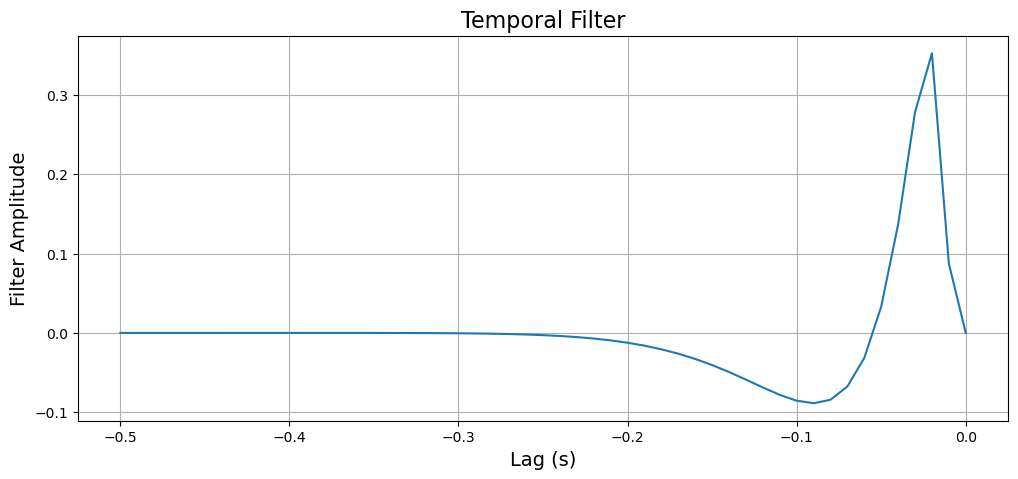

In [101]:
# Define filter
filter_bin_width_ms = 10
filter_length_ms = 500
num_filter_bins = int(filter_length_ms/filter_bin_width_ms + 1)

# Define the temporal filter function.
def temporalFun(t, p):
  return p[0] * (((t/p[1])**p[5])/(1+((t/p[1])**p[5]))) * np.exp(-((t/p[2]))) * np.cos(((2*np.pi*t)/p[3])+(2*np.pi*p[4]/360))

# Define temporal parameters.
tparams = [2.699101600403141, 0.017693386617024, 0.037119750110715, 0.586510918255136, 56.559161047519765, 4.001435007252049]


fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,5)

# Filter time base needs to be in seconds for these params.
t = np.linspace(0,filter_length_ms/1000,num_filter_bins)
tfilter = temporalFun(t, tparams)
plt.plot(-t, tfilter)
ax.set_title('Temporal Filter', fontsize=16)
ax.set_xlabel('Lag (s)', fontsize=14)
ax.set_ylabel('Filter Amplitude', fontsize=14)
ax.grid()

In [103]:
# Define a nonlinearity function.
def relu(x):
  return np.maximum(0.0, x)

def homogeneous_poisson(rate, tmax, bin_size):
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    spikes = np.random.rand(nbins) < prob_of_spike
    return spikes * 1

60000 bins, 10ms/bin, 600s of gaussian stimulus


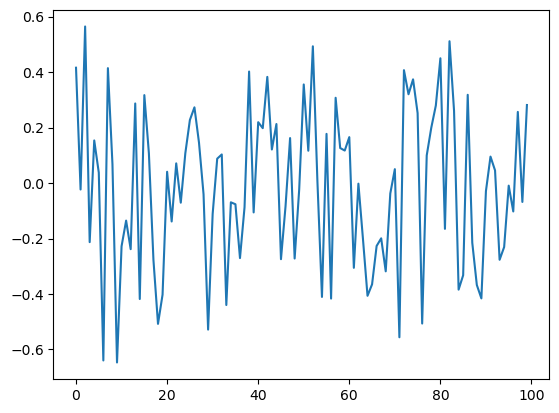

In [154]:
# Create gaussian stimulus
sd = 0.3 # Standard deviation of the Gaussian stimulus.
bin_width_ms = 10 # Bin width in milliseconds.
duration_ms = 1000 * 60 * 10 # Duration of the stimulus in milliseconds.
n_noise_bins = np.ceil(duration_ms / bin_width_ms).astype(int) # Number of time bins.
s = sd * np.random.normal(0, 1, n_noise_bins) # Try exponential(100, n_noise_bins) 
# What if we rectify stimulus 
# s = relu(s)

print(f'{n_noise_bins} bins, {bin_width_ms}ms/bin, {duration_ms/1000:.0f}s of gaussian stimulus')
plt.plot(s[:100])

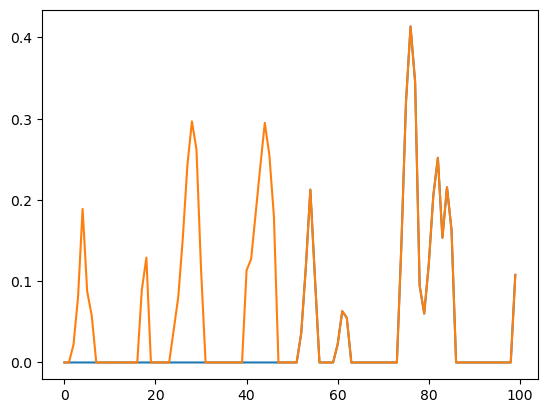

In [155]:
# Create the design matrix.
n = len(s)
filter_pts = len(tfilter)

S = np.zeros((n, filter_pts))
S[filter_pts-1:,:] = toeplitz(s[filter_pts-1:], s[:filter_pts][::-1])

# Convolve the stimulus with the filter.
r = np.dot(S, tfilter)

# In the Fourier domain, convolution is multiplication.
t_fft = np.arange(len(s))/1000.0*bin_width_ms
r_fft = np.real( np.fft.ifft( np.fft.fft(s) * np.fft.fft(temporalFun(t_fft, tparams)) ) )

# Pass through the ReLU nonlinearity.
r = relu(r)
r_fft = relu(r_fft)

plt.plot(r[:100])
plt.plot(r_fft[:100])

## Compute reverse correlation
Aka deconvolution

We have response r, and stimulus s, both 60,000 long. We want to reconstruct filter.

In [156]:
print(n, filter_pts, S.shape)

60000 51 (60000, 51)


In [157]:
# Loop method
sta_loop = np.zeros(filter_pts)
for idx_f in range(filter_pts):
    sta_loop[idx_f] = np.dot(r, S[:, idx_f]) 

In [158]:
# Matmul method
sta_mat = r @ S

print(np.allclose(sta_mat, sta_loop))

True


In [159]:
# FFT method
sta_fft = np.real(np.fft.ifft(np.fft.fft(r) * np.conj(np.fft.fft(s))))
sta_fft = sta_fft[:filter_pts]

I don't quite get why we time-reversed s in fft method. Is that implicitly done in previous methods?

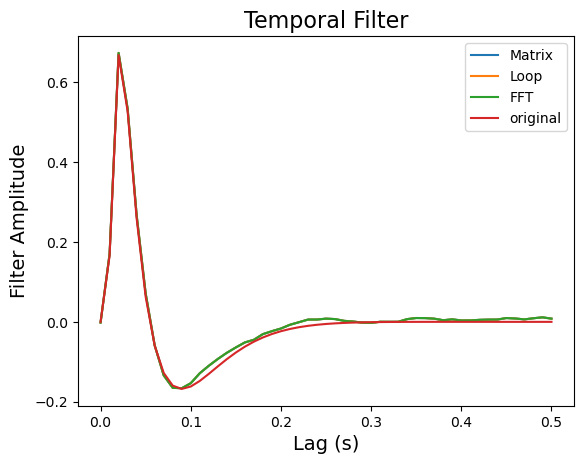

In [160]:
# Let's normalize the STA.
sta_mat = sta_mat / np.linalg.norm(sta_mat)
sta_loop = sta_loop / np.linalg.norm(sta_loop)
sta_fft = sta_fft / np.linalg.norm(sta_fft)

fig, ax = plt.subplots(1,1)
ax.plot(t, sta_mat, label='Matrix')
ax.plot(t, sta_loop, label='Loop')
ax.plot(t, sta_fft, label='FFT')
ax.plot(t, tfilter/np.linalg.norm(tfilter), label='original')
ax.set_title('Temporal Filter', fontsize=16)
ax.set_xlabel('Lag (s)', fontsize=14)
ax.set_ylabel('Filter Amplitude', fontsize=14)
ax.legend()

What's the connection between normalized filter magnitude and original filter magnitude? Is there a way to recover original magnitude? Why is unnormalized filter so large in magnitude?

## Exercises

### Try Haar filter

In [114]:
def filter_stimulus(s, tfilter, b_relu=True, b_poisson=False):
    n_s = len(s)
    n_f = len(tfilter)

    # Create design matrix
    S = np.zeros((n_s, n_f))
    S[n_f-1:, :] = toeplitz(s[n_f-1:], s[:n_f][::-1])

    # Convolve stimulus with filter
    r = np.dot(S, tfilter)

    if b_relu:
        r = relu(r)
    if b_poisson:
        print('Poisson not implemented')
    
    return r

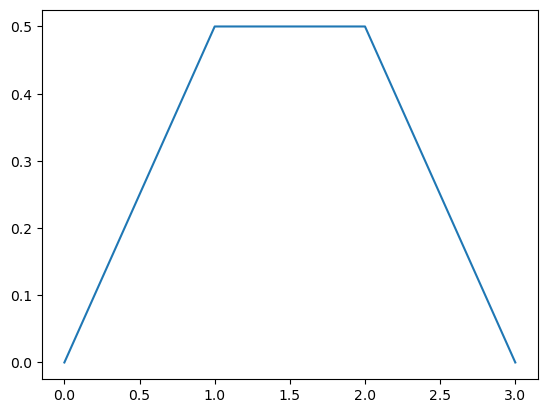

In [115]:
n_bins = 30
s = sd * np.random.normal(0, 1, n_bins)
haar_filter = np.array([0,0.5,0.5,0])
r_haar = filter_stimulus(s, haar_filter, b_relu=False)
plt.plot(haar_filter)

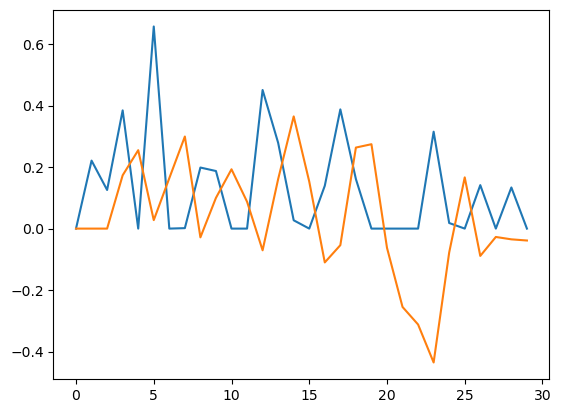

In [117]:
plt.plot(relu(s))#[:100])
plt.plot(r_haar)#[:100])

In [118]:
def reverse_corr(r, s, n_f=51, b_method='loop'):
    # Function to compute reverse correlation
    n_s = len(r)
    # Create design matrix
    S = np.zeros((n_s, n_f))
    S[n_f-1:, :] = toeplitz(s[n_f-1:], s[:n_f][::-1])

    if b_method=='loop':
        sta = np.zeros(n_f)
        for idx_f in range(n_f):
            sta[idx_f] = np.dot(S[:,idx_f], r)
        
    return sta

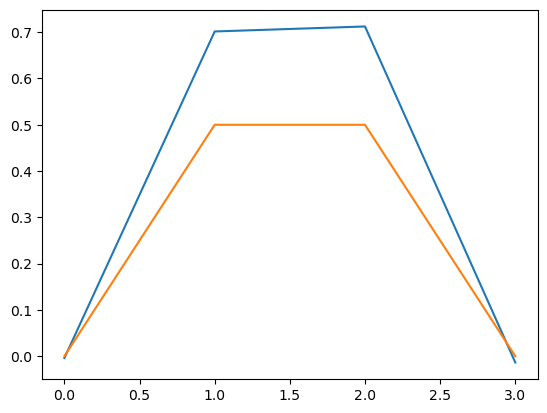

In [119]:
sta_haar = reverse_corr(r_haar, s, len(haar_filter))
plt.plot(sta_haar/np.linalg.norm(sta_haar))
plt.plot(haar_filter)

Unexpectedly, haar filter is recovered!!!